In [1]:
!git clone https://github.com/joerivc/MasterThesis.git

Cloning into 'MasterThesis'...
remote: Enumerating objects: 6826, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 6826 (delta 39), reused 31 (delta 24), pack-reused 6762
Receiving objects: 100% (6826/6826), 1.21 GiB | 14.84 MiB/s, done.
Resolving deltas: 100% (231/231), done.
Updating files: 100% (40478/40478), done.


In [2]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, \
    Conv2D, \
    MaxPooling2D, \
    Flatten, \
    BatchNormalization, \
    Dropout,\
    Rescaling
# from keras.preprocessing import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
import shutil

In [3]:
img_height = 256
img_width = 256
batch_size = 32

In [ ]:
def split_dataset(input_folder, output_folder, train_percent, val_percent, test_percent):
    # Create output folders if they don't exist
    for folder in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_folder, folder), exist_ok=True)

    # List all files in the input folder
    files = os.listdir(input_folder)
    num_files = len(files)

    # Shuffle the list of files
    random.shuffle(files)

    # Calculate the number of files for each set
    train_split = int(train_percent * num_files)
    val_split = int(val_percent * num_files)
    test_split = int(test_percent * num_files)

    # Copy files to corresponding sets
    for i, file in enumerate(files):
        if i < train_split:
            shutil.copy(os.path.join(input_folder, file), os.path.join(output_folder, 'train', file))
        elif i < train_split + val_split:
            shutil.copy(os.path.join(input_folder, file), os.path.join(output_folder, 'val', file))
        else:
            shutil.copy(os.path.join(input_folder, file), os.path.join(output_folder, 'test', file))

# Example usage:
input_folder = 'C:\\Users\\Joeri Van Cauwelaert\\Desktop\\Masterthesis\\machineLearning\\Images6Classes\\StandingPelvicRB'
output_folder = 'C:\\Users\\Joeri Van Cauwelaert\\Desktop\\Masterthesis\\machineLearning\\SplittedImages'
train_percent = 0.6
val_percent = 0.2
test_percent = 0.2

split_dataset(input_folder, output_folder, train_percent, val_percent, test_percent)

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/MasterThesis/SplittedImages/train',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/MasterThesis/SplittedImages/val',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height,img_width)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/MasterThesis/SplittedImages/test',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 1440 files belonging to 4 classes.
Found 480 files belonging to 4 classes.
Found 480 files belonging to 4 classes.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_ds)

In [6]:
class_names = train_ds.class_names
class_names

['Sitting', 'SittingPelvicR', 'Standing', 'StandingPelvicR']

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


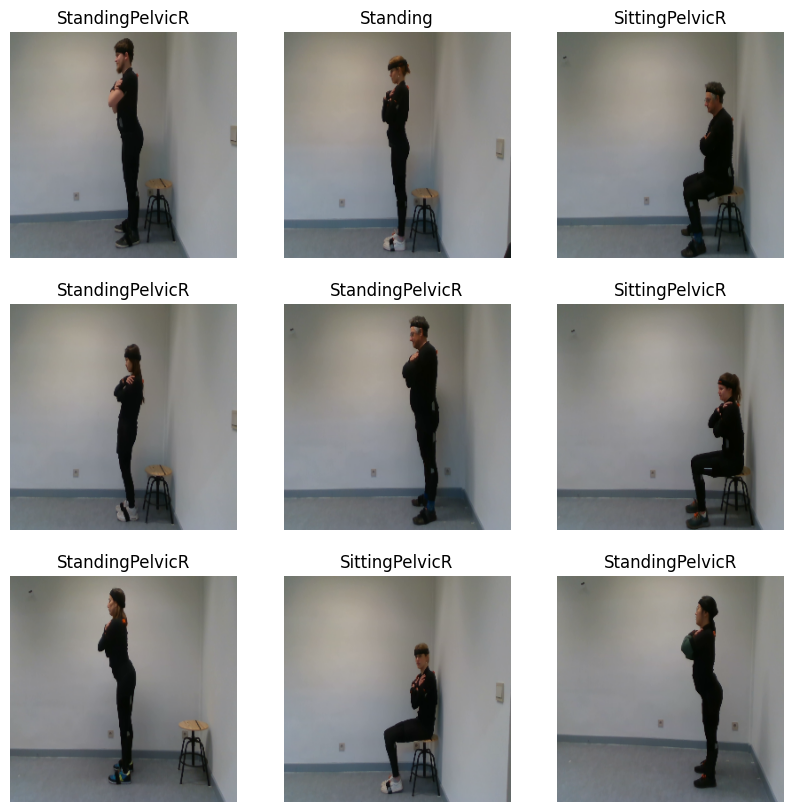

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet101(weights='imagenet', include_top=False)

# Add your own classification layer on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
base_learning_rate = 0.0005
model.compile(optimizer=Adam(learning_rate=base_learning_rate),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model (assuming you have train_dataset and val_dataset prepared)
model.fit(train_ds, epochs=30, validation_data=validation_ds)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

171446536/171446536 [==============================] - 8s 0us/step
Epoch 1/30
45/45 [==============================] - 18s 184ms/step - loss: 0.8166 - accuracy: 0.5722 - val_loss: 0.5466 - val_accuracy: 0.7188
Epoch 2/30
45/45 [==============================] - 7s 141ms/step - loss: 0.4881 - accuracy: 0.7736 - val_loss: 0.4511 - val_accuracy: 0.8000
Epoch 3/30
45/45 [==============================] - 7s 141ms/step - loss: 0.3863 - accuracy: 0.8597 - val_loss: 0.3996 - val_accuracy: 0.7979
Epoch 4/30
45/45 [==============================] - 7s 142ms/step - loss: 0.3316 - accuracy: 0.8785 - val_loss: 0.3033 - val_accuracy: 0.8938
Epoch 5/30
45/45 [==============================] - 7s 142ms/step - loss: 0.2673 - accuracy: 0.9208 - val_loss: 0.2537 - val_accuracy: 0.9458
Epoch 6/30
45/45 [==============================] - 7s 142ms/step - loss: 0.2145 - accuracy: 0.9500 - val_loss: 0.2081 - val_accuracy: 0.9667
Epoch 7/30
45/45 [==============================] - 7s 143ms/step - loss: 0.1918

In [11]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

15/15 [==============================] - 2s 104ms/step - loss: 0.0236 - accuracy: 0.9958
Test loss: 0.023566560819745064
Test accuracy: 0.9958333373069763


1/1 [==============================] - 0s 36ms/step


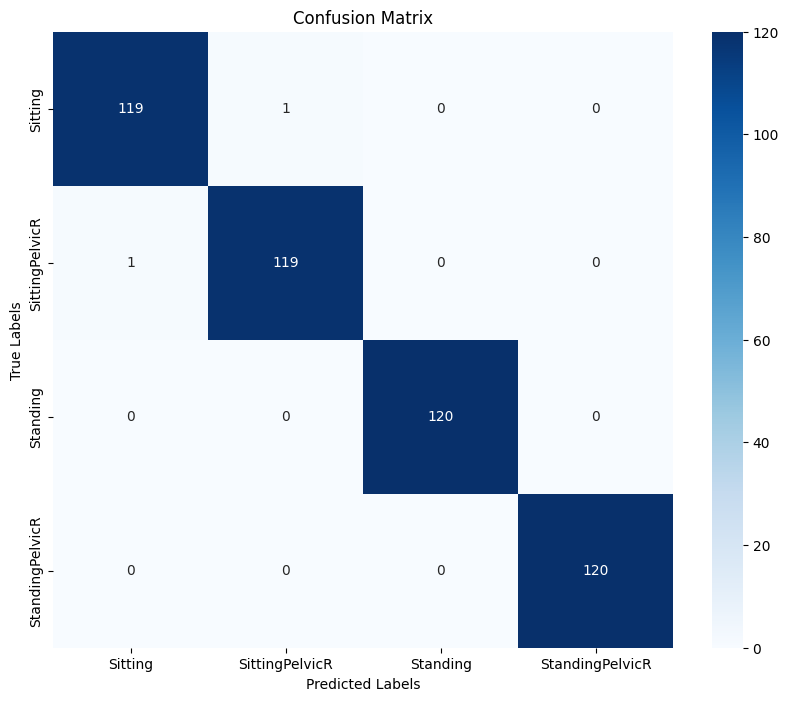

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have a test dataset with ground truth labels and model predictions
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect true and predicted labels
for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Assuming labels are in numpy arrays
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert probabilities to labels

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_ResNet101.png')
plt.show()

In [ ]:
model.export('resnet50_saved_model')

INFO:tensorflow:Assets written to: resnet50_saved_model\assets


INFO:tensorflow:Assets written to: resnet50_saved_model\assets


Saved artifact at 'resnet50_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2558903030880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903031936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903158208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903158912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903033696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903157152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903229600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903230128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903246688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903263824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2558903244928: TensorSpec(